# Day 03 — Customer Churn Prediction Pipeline (KNN + API Integration Ready)

## Objective
Build a machine learning pipeline that:
- Cleans customer churn data
- Preprocesses categorical & numeric features
- Trains a tuned KNN model with GridSearchCV
- Saves the best model for API usage
- Prepares system for dashboard/API integration

## Dataset
Kaggle Telco Customer Churn  
Source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

---

## Architecture for this Project
Training Notebook → Saved Model → FastAPI → Streamlit Dashboard



### Install & Import

In [29]:
!pip install scikit-learn pandas numpy matplotlib seaborn joblib --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib , os

# 1️⃣ Load Dataset & Initial Audit
We import the CSV, inspect structure, and check for missing data and column types.

In [9]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# 2️⃣ Data Cleaning & Preprocessing
- Convert TotalCharges to numeric
- Remove missing/invalid rows
- Label Encode categorical features
- Remove non-predictive customerID field

In [10]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])

df = df.drop("customerID", axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


# 3️⃣ Exploratory Data Analysis (EDA)
We visualize churn balance and correlations to understand drivers.

C:\Users\Akshay\AppData\Local\Temp\ipykernel_17072\1388581670.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churn", data=df, palette="viridis")


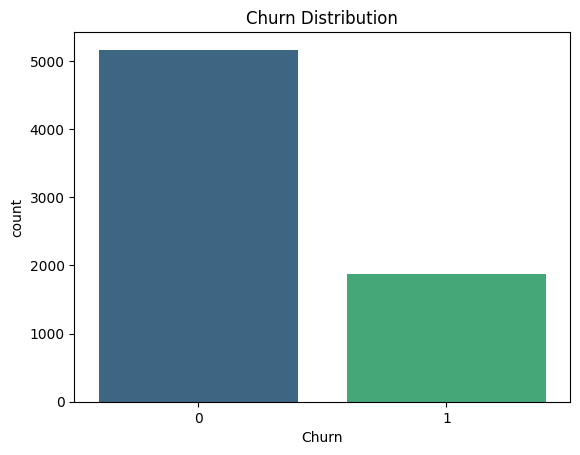

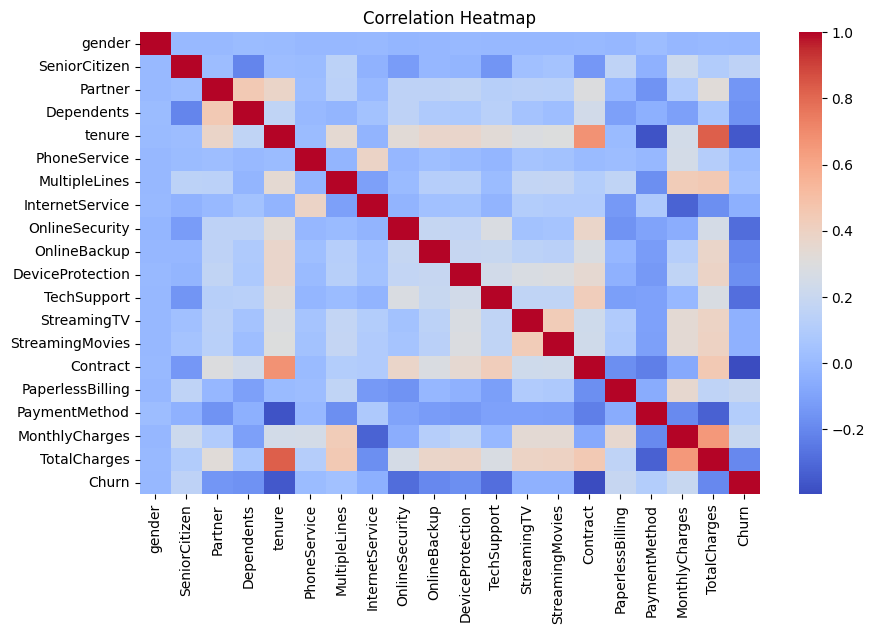

In [11]:
sns.countplot(x="Churn", data=df, palette="viridis")
plt.title("Churn Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 4️⃣ Train-Test Split

In [12]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Size:", X_train.shape, "| Test Size:", X_test.shape)

Train Size: (5274, 19) | Test Size: (1758, 19)


# 5️⃣ Build a Full Pipeline (Preprocessor + Model)
This ensures **scaling, encoding, model training** happen together:

In [23]:
numeric_features = ["tenure","MonthlyCharges","TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("knn", KNeighborsClassifier())
])

pipeline

,steps,"[('prep', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 6️⃣ Hyperparameter Tuning (GridSearchCV)

In [24]:
param_grid = {
    "knn__n_neighbors":[3,5,7,9,11],
    "knn__weights":["uniform","distance"],
    "knn__metric":["euclidean","manhattan"]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", round(grid.best_score_, 3))

Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Best Score: 0.783


# 7️⃣ Final Model Evaluation

Accuracy: 0.776

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1300
           1       0.57      0.57      0.57       458

    accuracy                           0.78      1758
   macro avg       0.71      0.71      0.71      1758
weighted avg       0.78      0.78      0.78      1758



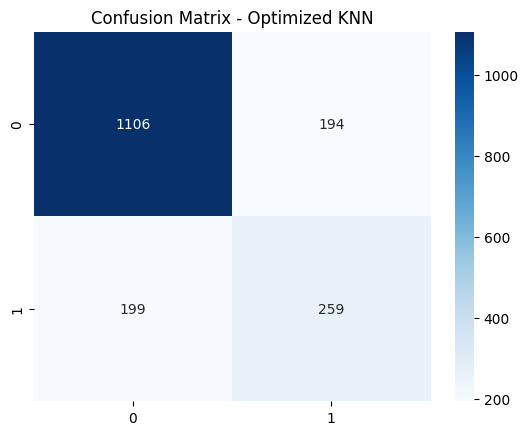

In [25]:
# Evaluation
y_pred = grid.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Optimized KNN")
plt.show()

In [26]:
# Cross Validation
scores = cross_val_score(grid.best_estimator_, X, y, cv=10)
scores.mean(), scores.std()

(np.float64(0.782989097051597), np.float64(0.012004737370709496))

# 8️⃣ Save Production Model

In [30]:
os.makedirs("model", exist_ok=True)
joblib.dump(grid.best_estimator_, "model/churn_knn_pipeline.pkl")
print("Saved → model/churn_knn_pipeline.pkl")

Saved → model/churn_knn_pipeline.pkl


# 9️⃣ Predict on a New Customer (for API usage)

In [31]:
sample = pd.DataFrame([{
    "gender": 1,
    "SeniorCitizen": 0,
    "Partner": 1,
    "Dependents": 0,
    "tenure": 12,
    "PhoneService": 1,
    "MultipleLines": 0,
    "InternetService": 2,
    "OnlineSecurity": 1,
    "OnlineBackup": 0,
    "DeviceProtection": 1,
    "TechSupport": 0,
    "StreamingTV": 1,
    "StreamingMovies": 1,
    "Contract": 1,
    "PaperlessBilling": 1,
    "PaymentMethod": 2,
    "MonthlyCharges": 65.5,
    "TotalCharges": 785.2
}])

pred = grid.predict(sample)
print("Churn Prediction:", "Likely to Leave" if pred[0] == 1 else "Likely to Stay")

Churn Prediction: Likely to Stay


# ✅ Notebook Completed

The following output files are now ready for production pipeline use:
- `churn_knn_model.pkl` → ML model for API & dashboard
- Notebook can now connect to:
    - **FastAPI** → via POST /predict
    - **Streamlit Dashboard** → UI for business users

Next Step:
➡ Build `/api/app.py` (FastAPI)
➡ Build `/dashboard/dashboard.py` (Streamlit UI)
